# Libraries

In [31]:
%pip install pyEDFlib 

import numpy as np
import random
import time
import pandas as pd
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

from pyedflib import highlevel
import pyedflib as plib

Note: you may need to restart the kernel to use updated packages.


# Raw data

In [2]:
path0 = os.getcwd()

path_files = os.path.join(path0, "files")

In [3]:
def loadEEG(subject,record):  #lectura del .edf

	# formatting
	if isinstance(record, int):
		record = "{:02d}".format(record)
	if isinstance(subject, int):
		subject = "{:03d}".format(subject)

	path = os.path.join(path_files, "S" + subject, "S" + subject + "R" + record +'.edf')

	signals, signal_headers, header = highlevel.read_edf(path)

	return signals, signal_headers, header


In [6]:
signals, signal_headers, header = loadEEG(1,"14")

In [5]:
header['annotations']

[[0.0, 4.2, 'T0'],
 [4.2, 4.1, 'T2'],
 [8.3, 4.2, 'T0'],
 [12.5, 4.1, 'T1'],
 [16.6, 4.2, 'T0'],
 [20.8, 4.1, 'T2'],
 [24.9, 4.2, 'T0'],
 [29.1, 4.1, 'T1'],
 [33.2, 4.2, 'T0'],
 [37.4, 4.1, 'T1'],
 [41.5, 4.2, 'T0'],
 [45.7, 4.1, 'T2'],
 [49.8, 4.2, 'T0'],
 [54.0, 4.1, 'T1'],
 [58.1, 4.2, 'T0'],
 [62.3, 4.1, 'T2'],
 [66.4, 4.2, 'T0'],
 [70.6, 4.1, 'T1'],
 [74.7, 4.2, 'T0'],
 [78.9, 4.1, 'T2'],
 [83.0, 4.2, 'T0'],
 [87.2, 4.1, 'T2'],
 [91.3, 4.2, 'T0'],
 [95.5, 4.1, 'T1'],
 [99.6, 4.2, 'T0'],
 [103.8, 4.1, 'T2'],
 [107.9, 4.2, 'T0'],
 [112.1, 4.1, 'T1'],
 [116.2, 4.2, 'T0'],
 [120.4, 4.1, 'T2']]

In [10]:
r1 = [3,7,11]   # Realized One Hand (Left or Right)
i1 = [4,8,12]   # Imagined One Hand (Left or Right)
r2 = [5,9,13]   # Realized Two (Hands or Feet)
i2 = [6,10,14]  # Imagined Two (Hands or Feet)

codes = {'IL':(i1,'T1',0),'IR':(i1,'T2',1),'ILR':(i2,'T1',2),'IF':(i2,'T2',3),\
        'RL':(r1,'T1',4),'RR':(r1,'T2',5),'RLR':(r2,'T1',6), 'RF':(r2,'T2',7)}

# IL: Imagined Left Hand (label 0)            RL: Realized Left Hand (label 4)
# IR: Imagined Right Hand (label 1)           RR: Realized Right Hand  (label 5)
# ILR: Imagined Both Hands (label 2)          RLR: Realized Both Hands (label 6)
# IF: Imagined Both Feet (label 3)            RF: Realized Both Feet (label 7)



def GetSignal(subject, tarea, sample_rate=160, segment_length=640, selected_channels=None):
    '''
    GetSignal():
    Entrada:
    - subject: número de sujeto
    - tarea: 'IL', 'IR', 'ILR', 'IF', 'RL', 'RR', 'RLR', 'RF' (ver codes)
    - sample_rate: tasa de muestreo (Hz)
    - segment_length: longitud deseada del segmento (número de muestras)
    - selected_channels: lista de nombres de canales a seleccionar, si es None, usa todos.
    - 640 corresponde a los 4 seg a 160 Hz

    Salida:
    - sujeto: número de sujeto
    - data: lista de arrays de señal, cada array tiene tamaño (n_canales, segment_length)
    - labels: lista de etiquetas correspondientes a cada segmento
    - channels: nombres de canales seleccionados
    '''

    data = []  # Almacena los recortes de señales
    labels = []  # Almacena los numeros correspondientes a cada task
    channels = []  # Nombres de los canales seleccionados

    # Obtener información de la tarea
    run, T, label = codes[tarea]

    # Recorrer los índices en 'run' (r1, i1, r2, i2)
    for irec in run:
        # Cargar las señales usando el sujeto y registro
        signals, signal_headers, header = loadEEG(subject, irec)

        # Extraer los nombres de los canales
        channel_names = [header['label'] for header in signal_headers]

        # Si no se especifican canales seleccionados, usar todos los canales disponibles
        if selected_channels is None:
            selected_channels = channel_names  # Usa todos los canales disponibles

        # Filtrar solo los canales seleccionados
        try:
            selected_indices = [channel_names.index(ch) for ch in selected_channels]
        except ValueError as e:
            print(f"Error: Canal {e} no encontrado en los nombres de canales disponibles \
            {channel_names}")
            return subject, [], [], []

        # Filtrar las señales según los índices de canales seleccionados
        signals = signals[selected_indices, :]
        channels = [channel_names[i] for i in selected_indices]

        # Buscar anotaciones relevantes
        for notas in header['annotations']:
            if notas[2] == T:
                # Calcular índices de tiempo en la señal
                ti = int(sample_rate * notas[0])
                tf = ti + int(sample_rate * (notas[1]-0.095))  # resto 0.095 para tener 4 seg (XXX esto es necesario?)
                # Recortar la señal
                recorte = signals[:, ti:tf]

                # Verificar longitud del recorte
                if recorte.shape[1] == segment_length:
                    data.append(recorte)  # Agregar recorte a la lista de datos
                    labels.append(label)  # Agregar etiqueta correspondiente
                else:
                    print(f'Se descarta {subject} - {tarea}: longitud de recorte incorrecta '
                    f'({recorte.shape[1]} en lugar de {segment_length})')

    # Verificar si no se encontraron segmentos válidos
    if len(data) == 0:
        print(f'Se descarta {subject} - {tarea}: no se encontraron segmentos válidos.')
        return subject, [], [], []

    return subject, data, labels, channels


In [14]:
subject, data, labels, channels = GetSignal(12, 'IR', sample_rate=160, segment_length=640, selected_channels=None)

In [21]:
senal = data[0][0,:]
x = np.arange(len(senal))

In [23]:
senal.shape

(640,)

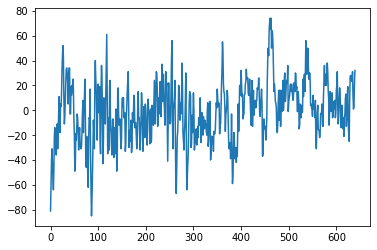

In [22]:
plt.plot(x, senal)

In [24]:
senal2 = data[0][2,:]


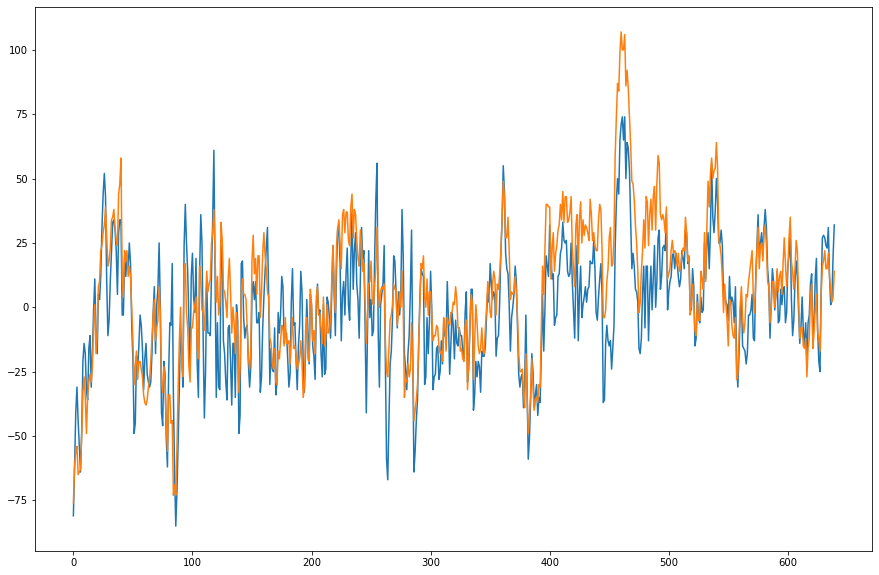

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(x, senal, senal2)

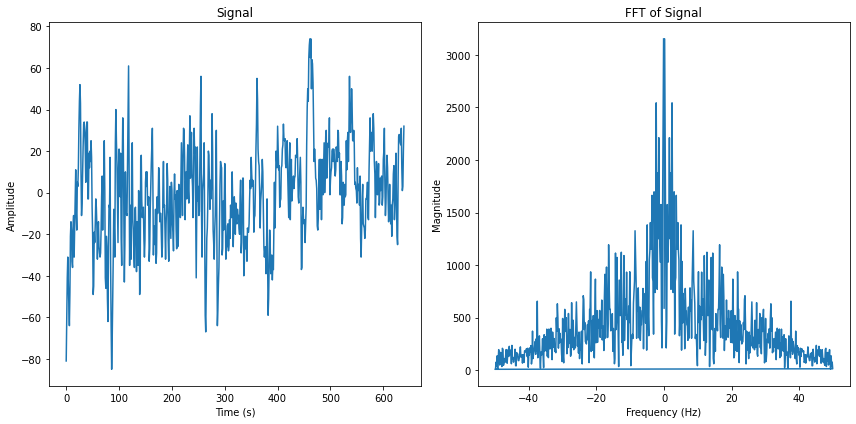

In [30]:
# Calculate the FFT of the signal
fs = 100.0
signal = senal

fft_signal = np.fft.fft(signal)

# Calculate the frequencies corresponding to the FFT components
freq = np.fft.fftfreq(len(signal), d=1/fs)

# Plot the signal and its FFT
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(x, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal')

plt.subplot(122)
plt.plot(freq, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Signal')

plt.tight_layout()
plt.show()